# Synthetic results analysis

In [7]:
import pandas as pd
import re
import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["figure.dpi"]     = 150

## Utils

In [8]:
def chamfer(df, prefix, legend, threshold_bnds=(0.00, 0.3), color="gray"):
    import matplotlib.pyplot as plt
    
    pattern = re.compile(r"refined_chamfer_(.*)")
    thresholds = []

    for col in df.columns:
        match = pattern.match(col)
        if match:
            thresholds.append(match.group(1))
        
    cd_t = []    
    t = []
    for th in thresholds:
        if float(th) < threshold_bnds[0] or float(th) > threshold_bnds[1]: continue
        cd = df[f"{prefix}_chamfer_{th}"].mean()
        cd_t.append(cd)
        t.append(float(th))
     
     
    plt.plot(t, cd_t, label=legend, color=color)
    plt.xlabel("Threshold [Prob]")
    plt.ylabel("d_chamfer [vox]")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    
    
def chamfer_adaptive(df, color="black", line="--", suffix="(diffusion)"):
    import matplotlib.pyplot as plt
    mean_val = df["refined_chamfer_adaptive"].mean()
    plt.axhline(
        y=mean_val,
        color=color,      # choose a color
        linestyle=line,     # dashed line for clarity
        linewidth=1.5,
        label=f"adaptive threshold mean ({mean_val:.2f}) [vox] {suffix}"
    )
    plt.legend(loc="right")
    plt.tight_layout()


def dice3d(df, prefix, legend, threshold_bnds=(0, 1), color="gray"):
    import matplotlib.pyplot as plt
    
    pattern = re.compile(r"refined_chamfer_(.*)")
    thresholds = []

    for col in df.columns:
        match = pattern.match(col)
        if match:
            thresholds.append(match.group(1))
        
    cd_t = []    
    t = []
    for th in thresholds:
        if float(th) < threshold_bnds[0] or float(th) > threshold_bnds[1]: continue
        cd = df[f"{prefix}_dice3d_{th}"].mean()
        cd_t.append(cd)
        t.append(float(th))
     
     
    plt.plot(t, cd_t, label=legend, color=color)
    plt.xlabel("Threshold [Prob]")
    plt.ylabel("Dice3d [Frac]")
    plt.title(f"Dice3d")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()


def dice3d_adaptive(df, color="black", line="--", suffix="(diffusion)"):
    import matplotlib.pyplot as plt
    mean_val = df["refined_dice3d_adaptive"].mean()
    plt.axhline(
        y=mean_val,
        color=color,      # choose a color
        linestyle=line,     # dashed line for clarity
        linewidth=1.5,
        label=f"adaptive threshold mean ({mean_val:.2f}) {suffix}"
    )
    plt.legend(loc="right")


def metric_difference(df, metric_name, log=False, inverted=False, color="gray", legend=""):
    pattern = re.compile(r"refined_dice3d_(.*)")
    thresholds = []

    for col in df.columns:
        match = pattern.match(col)
        if match:
            thresholds.append(match.group(1))
        
    d3d_t = []    
    t = []
    for th in thresholds:
        d3d = df[f"refined_{metric_name}_{th}"].mean()
        d3d_bp = df[f"backproj_{metric_name}_{th}"].mean()
        t.append(float(th))
        if inverted: d3d_t.append(d3d_bp - d3d)
        else: d3d_t.append(d3d - d3d_bp)

    import matplotlib.pyplot as plt

    plt.plot(t, d3d_t, color=color, label=legend)
    plt.ylabel("difference [Frac]")
    plt.xlabel("threshold [Prob]")
    if log: plt.yscale("log")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    
def metric_difference_adaptive(df, metric_name, color="black", line="--", suffix="(diffusion)"):
    import matplotlib.pyplot as plt
    mean_val = (df[f"refined_{metric_name}_adaptive"] - df[f"backproj_{metric_name}_adaptive"]).mean()
    plt.axhline(
        y=mean_val,
        color=color,      # choose a color
        linestyle=line,     # dashed line for clarity
        linewidth=1.5,
        label=f"adaptive threshold mean ({mean_val:.2f}) {suffix}"
    )
    plt.legend(loc="lower right")


def latex_make_table(h, v_ours, v_gan, caption="", label=""):
    table = r"\begin{table}\begin{center}\begin{tabular}{lc}" + "\n"
    table += r"\hline" + "\n"
    table += f"Model & {h} \\\\\n"
    table += r"\hline" + "\n"
    table += f"Ours & {v_ours:.2f} \\\\\n"
    table += f"Baseline (gan) & {v_gan:.2f} \\\\\n"
    table += r"\hline" + "\n"
    table += r"\end{tabular}\end{center}" + "\n"
    table += r"\caption{" + caption + r" \label{" + label + r"}}" + "\n"
    table += r"\end{table}" + "\n"
    return table


def mean_ci(series, n_boot=10000, confidence=0.95, seed=42):
    import numpy as np
    rng = np.random.default_rng(seed)
    data = series.dropna().values
    means = [np.mean(rng.choice(data, size=len(data), replace=True)) for _ in range(n_boot)]
    lower, upper = np.percentile(means, [(1 - confidence) / 2 * 100, (1 + confidence) / 2 * 100])
    return np.mean(data), lower, upper

def ci_pretty(df, col):
    mean, lo, hi = mean_ci(df[col])
    print(f"{mean:.2f} ({lo:.2f}-{hi:.2f})")

## Right

In [9]:
df_diffusion = pd.read_csv("../data/synthetic_diffusion_right.csv")
df_unet = pd.read_csv("../data/synthetic_unet_right.csv")

df_adaptive_diffusion = pd.read_csv("../data/synthetic_adaptive_diffusion_right.csv")
df_adaptive_unet = pd.read_csv("../data/synthetic_adaptive_unet_right.csv")

df_best_diffusion = pd.read_csv("../data/synthetic_both_right.csv")


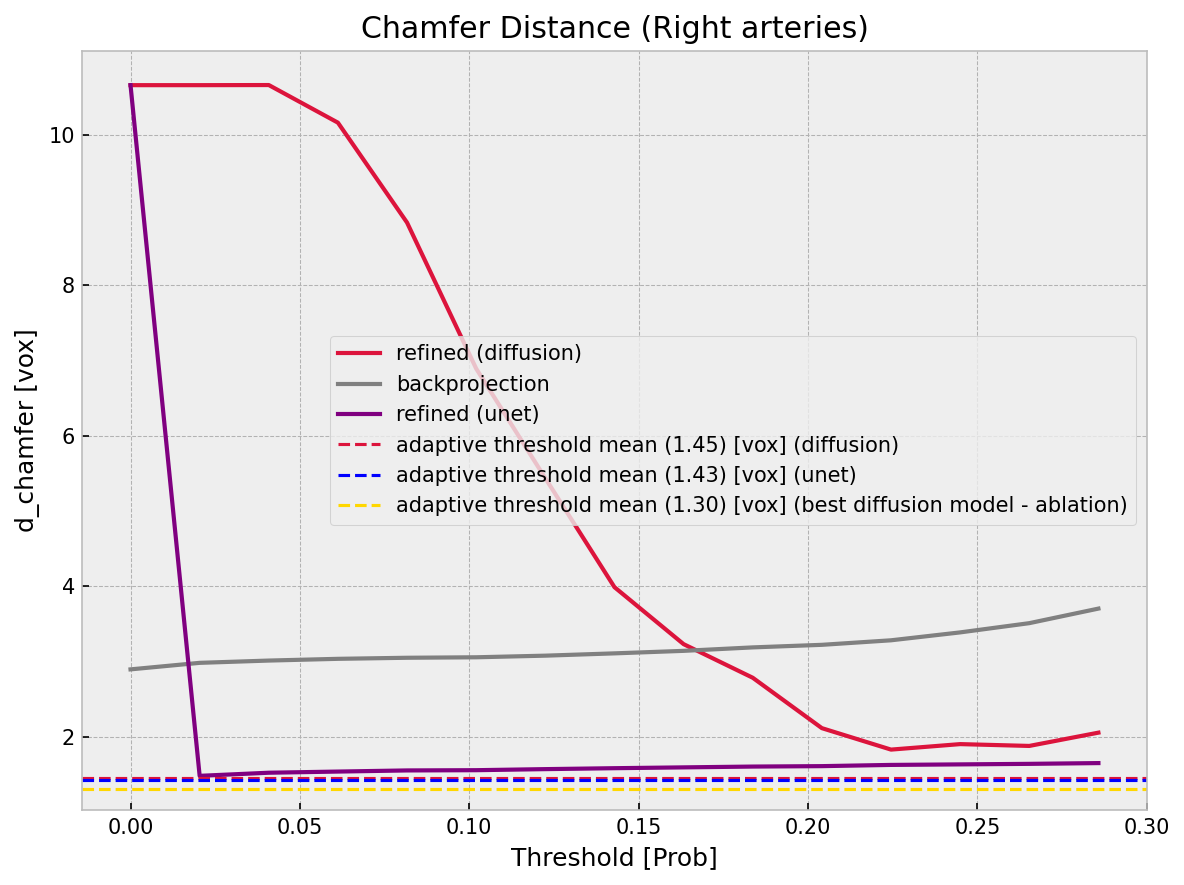

In [10]:
plt.title(f"Chamfer Distance (Right arteries)")
chamfer(df_diffusion, prefix="refined", legend="refined (diffusion)", color="crimson")
chamfer(df_diffusion, prefix="backproj", legend="backprojection", color="gray")
chamfer(df_unet, prefix="refined", legend="refined (unet)", color="purple")
chamfer_adaptive(df_adaptive_diffusion, color="crimson")
chamfer_adaptive(df_adaptive_unet, color="blue", suffix="(unet)")
chamfer_adaptive(df_best_diffusion, color="gold", suffix="(best diffusion model - ablation)")


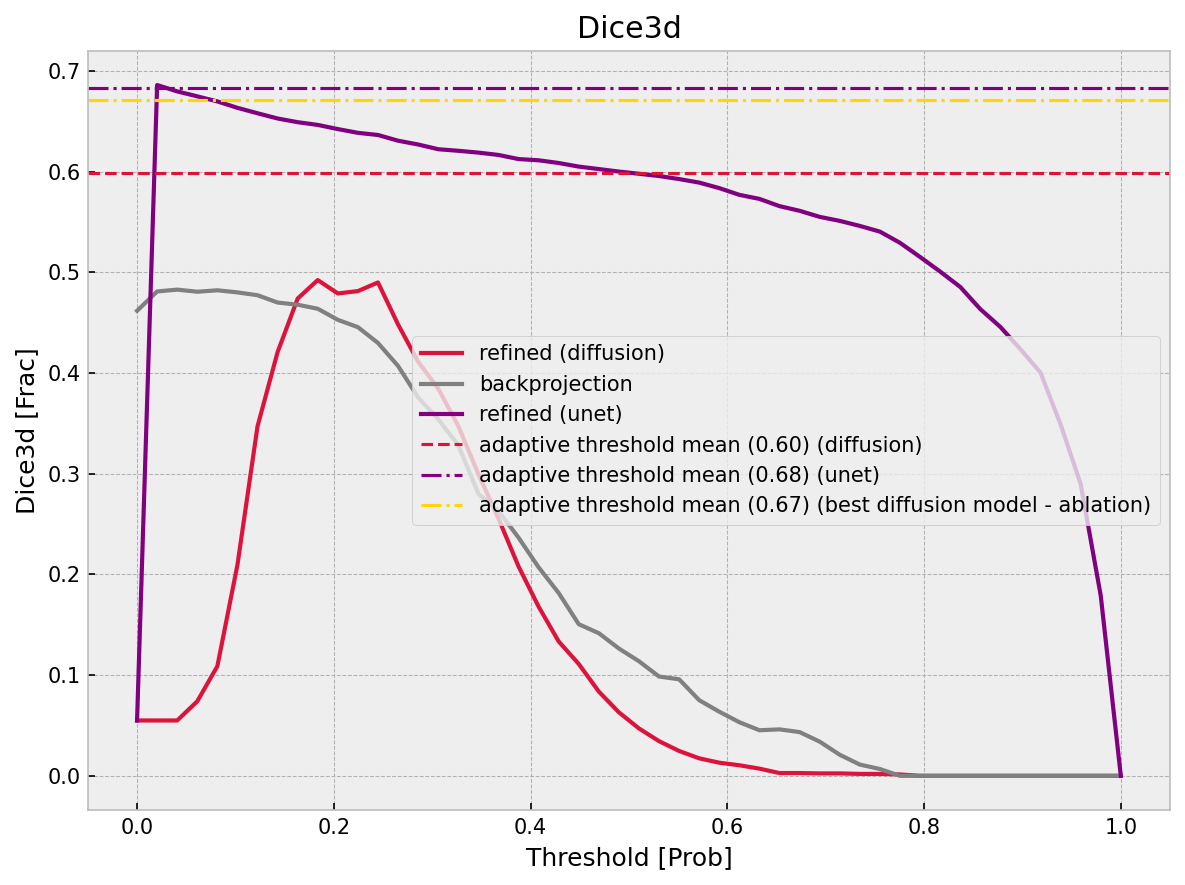

In [11]:
dice3d(df_diffusion, prefix="refined", legend="refined (diffusion)", color="crimson")
dice3d(df_diffusion, prefix="backproj", legend="backprojection", color="gray")
dice3d(df_unet, prefix="refined", legend="refined (unet)", color="purple")
dice3d_adaptive(df_adaptive_diffusion, color="crimson")
dice3d_adaptive(df_adaptive_unet, color="purple", line="-.", suffix="(unet)")
dice3d_adaptive(df_best_diffusion, color="gold", line="-.", suffix="(best diffusion model - ablation)")

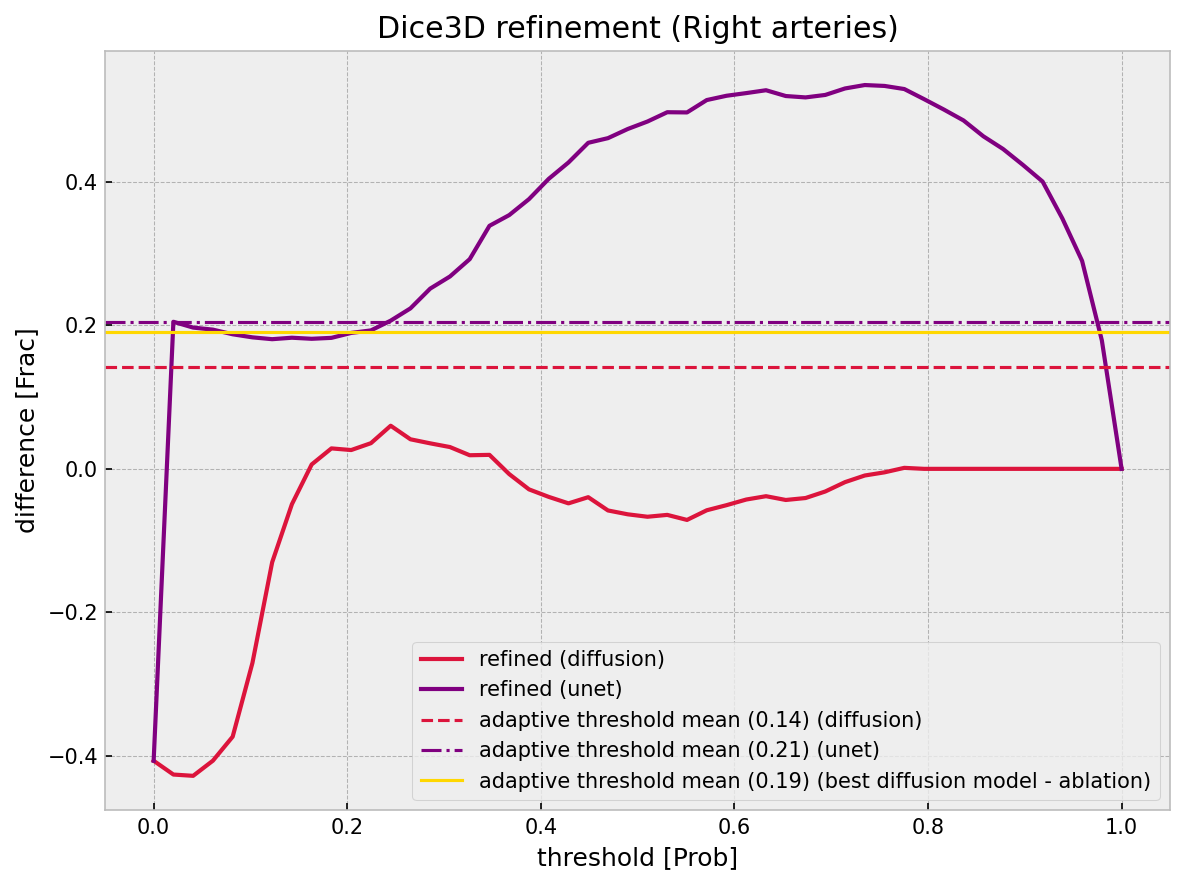

In [12]:
   
plt.title(f"Dice3D refinement (Right arteries)")

metric_difference(df_diffusion, "dice3d", color="crimson", legend="refined (diffusion)")
metric_difference(df_unet, "dice3d", color="purple", legend="refined (unet)")
metric_difference_adaptive(df_adaptive_diffusion, "dice3d", color="crimson")
metric_difference_adaptive(df_adaptive_unet, "dice3d", color="purple", line="-.", suffix="(unet)")
metric_difference_adaptive(df_best_diffusion, "dice3d", color="gold", line="-", suffix="(best diffusion model - ablation)")

In [13]:
ci_pretty(df_adaptive_diffusion, "refined_chamfer_adaptive")
ci_pretty(df_adaptive_diffusion, "refined_dice3d_adaptive")
ci_pretty(df_adaptive_diffusion, "PSNR")
ci_pretty(df_adaptive_diffusion, "elapsed")

ci_pretty(df_adaptive_diffusion, "chamfer_distance0")
ci_pretty(df_adaptive_diffusion, "chamfer_distance1")
ci_pretty(df_adaptive_diffusion, "dice2d0")
ci_pretty(df_adaptive_diffusion, "dice2d1")

ci_pretty(df_adaptive_diffusion, "interpret_frac")

1.45 (1.30-1.64)
0.60 (0.57-0.63)
30.30 (29.36-31.24)
2.71 (2.70-2.72)
9.33 (7.96-10.74)
6.12 (5.29-6.99)
0.42 (0.37-0.46)
0.56 (0.53-0.59)
0.13 (0.11-0.14)


In [14]:
ci_pretty(df_adaptive_unet, "refined_chamfer_adaptive")
ci_pretty(df_adaptive_unet, "refined_dice3d_adaptive")
ci_pretty(df_adaptive_unet, "PSNR")
ci_pretty(df_adaptive_unet, "elapsed")

ci_pretty(df_adaptive_unet, "chamfer_distance0")
ci_pretty(df_adaptive_unet, "chamfer_distance1")
ci_pretty(df_adaptive_unet, "dice2d0")
ci_pretty(df_adaptive_unet, "dice2d1")

ci_pretty(df_adaptive_unet, "interpret_frac")

1.43 (1.23-1.66)
0.68 (0.65-0.71)
36.44 (35.97-36.90)
0.03 (0.01-0.08)
8.78 (6.90-10.74)
6.30 (5.01-7.64)
0.46 (0.41-0.52)
0.57 (0.53-0.61)
0.26 (0.21-0.31)


In [15]:
ci_pretty(df_best_diffusion, "refined_chamfer_adaptive")
ci_pretty(df_best_diffusion, "refined_dice3d_adaptive")
ci_pretty(df_best_diffusion, "PSNR")
ci_pretty(df_best_diffusion, "elapsed")

ci_pretty(df_best_diffusion, "chamfer_distance0")
ci_pretty(df_best_diffusion, "chamfer_distance1")
ci_pretty(df_best_diffusion, "dice2d0")
ci_pretty(df_best_diffusion, "dice2d1")

ci_pretty(df_best_diffusion, "interpret_frac")

1.30 (1.17-1.43)
0.67 (0.65-0.69)
32.87 (32.14-33.56)
3.43 (3.35-3.52)
7.34 (6.08-8.70)
5.20 (4.33-6.18)
0.50 (0.45-0.55)
0.62 (0.59-0.65)
0.17 (0.15-0.19)


# Left

In [21]:
df_diffusion = pd.read_csv("../data/synthetic_diffusion_left.csv")
df_adaptive_diffusion = pd.read_csv("../data/synthetic_adaptive_diffusion_left.csv")
df_best_diffusion = pd.read_csv("../data/synthetic_no_projections_left.csv")
df_unet = pd.read_csv("../data/synthetic_unet_left.csv")
df_adaptive_unet = pd.read_csv("../data/synthetic_adaptive_unet_left.csv")
df_best_diffusion = pd.read_csv("../data/synthetic_no_projections_left.csv")


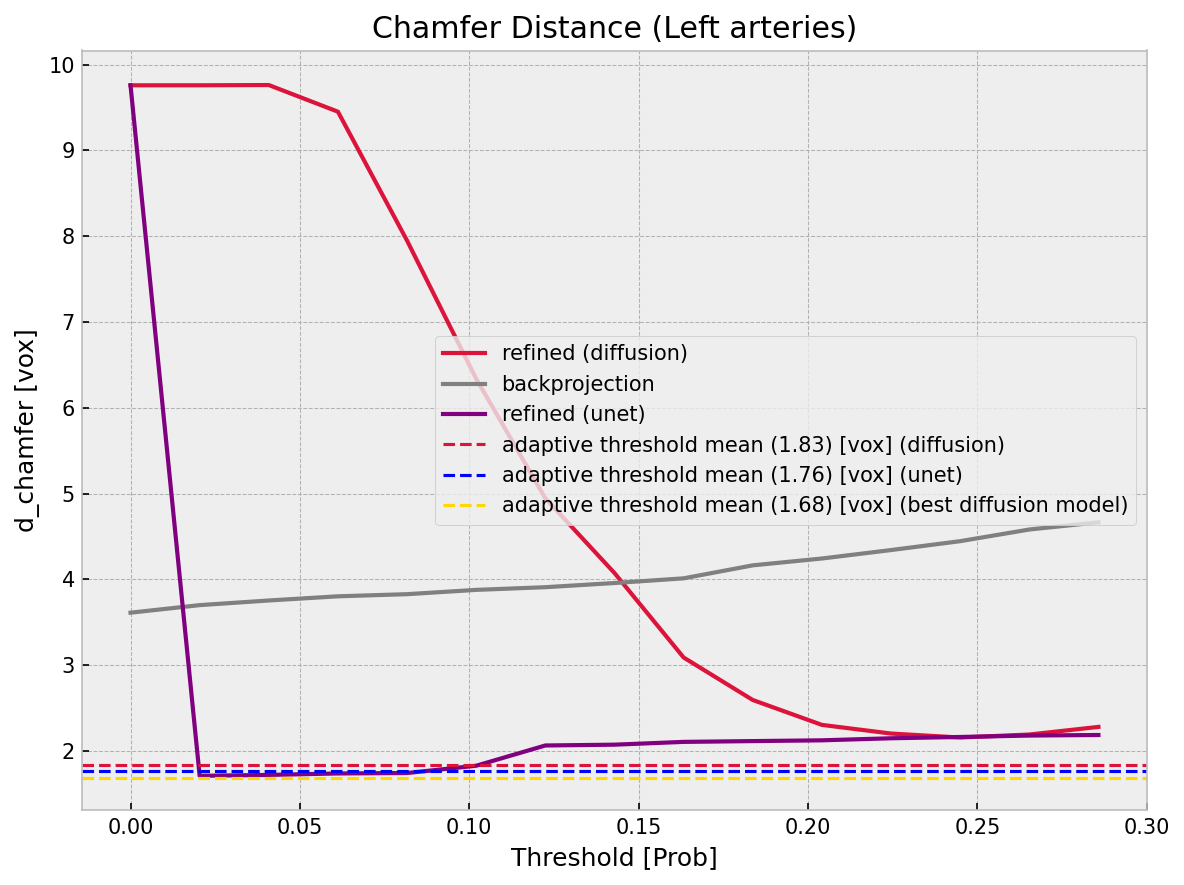

In [22]:
plt.title(f"Chamfer Distance (Left arteries)")
chamfer(df_diffusion, prefix="refined", legend="refined (diffusion)", color="crimson")
chamfer(df_diffusion, prefix="backproj", legend="backprojection", color="gray")
chamfer(df_unet, prefix="refined", legend="refined (unet)", color="purple")
chamfer_adaptive(df_adaptive_diffusion, color="crimson")
chamfer_adaptive(df_adaptive_unet, color="blue", suffix="(unet)")
chamfer_adaptive(df_best_diffusion, color="gold", suffix="(best diffusion model)")


In [23]:
ci_pretty(df_adaptive_diffusion, "refined_chamfer_adaptive")
ci_pretty(df_adaptive_diffusion, "refined_dice3d_adaptive")
ci_pretty(df_adaptive_diffusion, "PSNR")
ci_pretty(df_adaptive_diffusion, "elapsed")

ci_pretty(df_adaptive_diffusion, "chamfer_distance0")
ci_pretty(df_adaptive_diffusion, "chamfer_distance1")
ci_pretty(df_adaptive_diffusion, "dice2d0")
ci_pretty(df_adaptive_diffusion, "dice2d1")

ci_pretty(df_adaptive_diffusion, "interpret_frac")

1.83 (1.53-2.19)
0.56 (0.53-0.59)
27.81 (27.10-28.52)
3.47 (3.40-3.55)
8.38 (6.16-11.00)
10.17 (8.02-12.76)
0.59 (0.55-0.63)
0.48 (0.45-0.52)
0.23 (0.21-0.25)


In [24]:
ci_pretty(df_adaptive_unet, "refined_chamfer_adaptive")
ci_pretty(df_adaptive_unet, "refined_dice3d_adaptive")
ci_pretty(df_adaptive_unet, "PSNR")
ci_pretty(df_adaptive_unet, "elapsed")

ci_pretty(df_adaptive_unet, "chamfer_distance0")
ci_pretty(df_adaptive_unet, "chamfer_distance1")
ci_pretty(df_adaptive_unet, "dice2d0")
ci_pretty(df_adaptive_unet, "dice2d1")

ci_pretty(df_adaptive_unet, "interpret_frac")

1.76 (1.28-2.53)
0.63 (0.56-0.68)
35.57 (34.51-37.24)
0.02 (0.01-0.04)
8.15 (4.67-13.97)
11.19 (6.93-17.20)
0.58 (0.51-0.63)
0.49 (0.42-0.56)
0.42 (0.35-0.49)


In [25]:
ci_pretty(df_best_diffusion, "refined_chamfer_adaptive")
ci_pretty(df_best_diffusion, "refined_dice3d_adaptive")
ci_pretty(df_best_diffusion, "PSNR")
ci_pretty(df_best_diffusion, "elapsed")

ci_pretty(df_best_diffusion, "chamfer_distance0")
ci_pretty(df_best_diffusion, "chamfer_distance1")
ci_pretty(df_best_diffusion, "dice2d0")
ci_pretty(df_best_diffusion, "dice2d1")

ci_pretty(df_best_diffusion, "interpret_frac")

1.68 (1.40-2.03)
0.62 (0.58-0.66)
29.10 (28.41-29.80)
3.36 (3.30-3.43)
6.75 (4.72-9.38)
8.88 (6.60-11.62)
0.62 (0.58-0.66)
0.54 (0.49-0.58)
0.33 (0.30-0.37)
